In [28]:
import transformers
import pandas as pd
import numpy as np
import nltk
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score
from collections import defaultdict
import numpy as np
import torch
import sys
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [29]:
from torch.utils.data import Dataset, DataLoader
import torch
import pandas as pd
from sklearn.model_selection import train_test_split

class TweetsDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer):
        self.tweets = tweets; 
        self. labels = labels;
        self.tokenizer = tokenizer
        self.max_len = 512
    def __len__(self):
        return len(self.tweets)
    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens = True,
            max_length=self.max_len,
            truncation = True,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'tweet': tweet, 
            'input_ids': encoding['input_ids'].long().flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def split_test_val(df, valid_size = 0.15):
    X_train, X_val, y_train, y_val = train_test_split(df[['tweets']], df['labels'],stratify=df['labels'], test_size=valid_size, random_state = 0)
    df_train = pd.concat([pd.DataFrame({'tweets': X_train['tweets'].values}),pd.DataFrame({'labels': y_train.values})], axis = 1)
    df_valid = pd.concat([pd.DataFrame({'tweets': X_val['tweets'].values}),pd.DataFrame({'labels': y_val.values})], axis = 1)
    return df_train, df_valid


def create_data_loader(df, tokenizer, batch_size = 16):
    ds = TweetsDataset(
        tweets=df.tweets.to_numpy(),
        labels=df.labels.to_numpy(),
        tokenizer=tokenizer
    )
    return DataLoader(
        ds,
        batch_size=batch_size
    )

## Carga del tokenizador y el modelo preentrenado

In [30]:
tokenizer = transformers.AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
model = transformers.BertForSequenceClassification.from_pretrained("dccuchile/bert-base-spanish-wwm-cased", num_labels=4)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

## Conjunto de datos

In [31]:
df = pd.read_csv("./data/procesed.csv")
df_train, df_valid = split_test_val(df, valid_size=0.15)
train_data_loader = create_data_loader(df_train, tokenizer, batch_size=8)
valid_data_loader = create_data_loader(df_valid, tokenizer, batch_size=8)

## Parámetros del entrenamiento

In [32]:
model = model.to(device)
EPOCHS = 2
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = len(df_train) * EPOCHS
)

## Entrenamiento del modelo

In [33]:
import torch.nn.functional as F
import sys

def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in tqdm(data_loader):
        loss, logits = model(
            input_ids=d["input_ids"].to(device),
            attention_mask=d["attention_mask"].to(device),
            labels=F.one_hot(d['labels'].to(device), num_classes=4).float(),
            return_dict=False
        )
        logits = logits.detach().cpu().numpy()
        label_ids = d['labels'].cpu().flatten().numpy()
        preds = np.argmax(logits, axis=1).flatten()
        targ = d['labels'].numpy()
        correct_predictions += np.sum(preds==targ)
        losses.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions / n_examples, np.mean(losses)

def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            loss, logits = model(
                input_ids = d["input_ids"].to(device),
                attention_mask = d["attention_mask"].to(device),
                labels = F.one_hot(d['labels'].to(device), num_classes=4).float(),
                return_dict=False
            )
            logits = logits.detach().cpu().numpy()
            labels_ids = d['labels'].cpu().flatten().numpy()
            preds = np.argmax(logits, axis=1).flatten()
            targ = d['labels'].numpy()
            correct_predictions += np.sum(preds==targ)
            losses.append(loss.item())
        return correct_predictions / n_examples, np.mean(losses)

In [34]:
from collections import defaultdict
history = defaultdict(list)
best_acc = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-'*10)   
    train_acc, train_loss = train_epoch(model, train_data_loader, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} Accuracy {train_acc}')
    val_acc, val_loss = eval_model(model, valid_data_loader, device, len(df_valid))
    print(f'Val loss {val_loss} Accuracy {val_acc}')
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_acc:
#         torch.save(model.state_dict(), 'best_model_state_a5.bin')
        best_acc = val_acc

Epoch 1/2
----------


100%|██████████| 1530/1530 [13:33<00:00,  1.88it/s]


Train loss 0.5107777139330222 Accuracy 0.43251633986928106
Val loss 0.4906932044912268 Accuracy 0.4861111111111111
Epoch 2/2
----------


100%|██████████| 1530/1530 [13:33<00:00,  1.88it/s]


Train loss 0.40482713630289036 Accuracy 0.6159313725490196
Val loss 0.539677448074023 Accuracy 0.49953703703703706


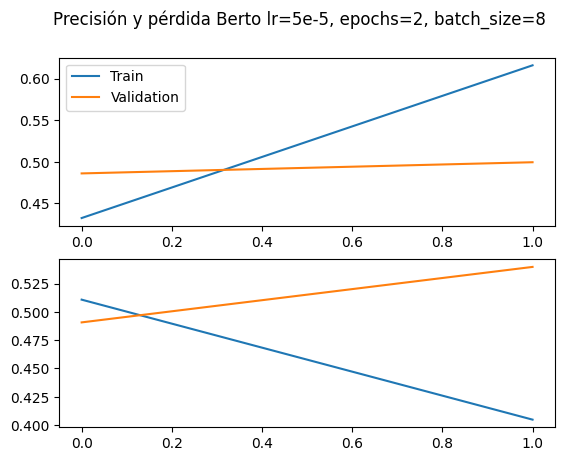

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
def plot_train_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(2)
    ax1.plot(history["train_acc"], label = "Train")
    ax1.plot(history["val_acc"], label="Validation")
    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["val_loss"], label="Validation")
    ax1.legend()
    fig.suptitle(f'Precisión y pérdida {model_name} lr=5e-5, epochs=2, batch_size=8')
plot_train_history(history, 'Berto')

In [ ]:
torch.save(model.state_dict(), 'berto-base-cased.bin')

## Prueba del modelo

In [38]:
def test(model, test_data_loader, device, test_len):
    model = model.eval()
    correct_predictions = 0
    losses = []
    with torch.no_grad():
        for d in tqdm(test_data_loader):
            loss, logits = model(
                input_ids = d["input_ids"].to(device),
                attention_mask = d["attention_mask"].to(device),
                labels = F.one_hot(d["labels"].to(device), num_classes=4).float(),
                return_dict=False
            )
            logits = logits.detach().cpu().numpy()
            labels_ids = d['labels'].cpu().flatten().numpy()
            preds = np.argmax(logits, axis=1).flatten()
            targ = d['labels'].numpy()
            correct_predictions += np.sum(preds==targ)
            losses.append(loss.item())
    return correct_predictions / test_len, np.mean(losses)

In [39]:
# Test
df_test = pd.read_csv('./data/procesed_test.csv')
test_data_loader = create_data_loader(df_test, tokenizer)
acc, loss = test(model, test_data_loader, device, len(df_test))
print(f"Result acc: {acc} loss: {loss}")

100%|██████████| 225/225 [01:33<00:00,  2.40it/s]

Result acc: 0.4691666666666667 loss: 0.58069854138626
